In [44]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [45]:
Data = pd.read_json('user-wallet-transactions.json')
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   _id          100000 non-null  object        
 1   userWallet   100000 non-null  object        
 2   network      100000 non-null  object        
 3   protocol     100000 non-null  object        
 4   txHash       100000 non-null  object        
 5   logId        100000 non-null  object        
 6   timestamp    100000 non-null  datetime64[ns]
 7   blockNumber  100000 non-null  int64         
 8   action       100000 non-null  object        
 9   actionData   100000 non-null  object        
 10  __v          100000 non-null  int64         
 11  createdAt    100000 non-null  object        
 12  updatedAt    100000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 9.9+ MB


In [46]:
Data.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [47]:
Data.shape

(100000, 13)

# 1.Data Preprocessing Function

In [48]:
file_path='user-wallet-transactions.json'

def data_preprocessing(file_path):
    try:
        with open(file_path, 'r') as f:
            raw = json.load(f)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return pd.DataFrame()
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON in '{file_path}'.")
        return pd.DataFrame()

    df = pd.DataFrame(raw)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

    def parse_date(val):
        if isinstance(val, dict) and '$date' in val:
            return val['$date']
        return val

    df['createdAt'] = pd.to_datetime(df['createdAt'].map(parse_date), errors='coerce')
    df['updatedAt'] = pd.to_datetime(df['updatedAt'].map(parse_date), errors='coerce')

    df['amount'] = df['actionData'].map(lambda x: x.get('amount') if isinstance(x, dict) else None)
    df['assetPriceUSD'] = df['actionData'].map(lambda x: x.get('assetPriceUSD') if isinstance(x, dict) else None)

    df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
    df['assetPriceUSD'] = pd.to_numeric(df['assetPriceUSD'], errors='coerce')

    df['usd_value'] = df['amount'] * df['assetPriceUSD']
    df['usd_value'].fillna(0, inplace=True)

    return df


# 2.Feature Engineering Function

In [49]:
def feature_extract(df):
    if df.empty:
        print("DataFrame is empty, cannot engineer features.")
        return pd.DataFrame()

    grp = df.groupby('userWallet')

    features = grp.agg(
        total_transactions=('txHash', 'nunique'),
        first_transaction_date=('timestamp', 'min'),
        last_transaction_date=('timestamp', 'max'),
        num_unique_protocols=('protocol', 'nunique'),
        num_unique_assets=('actionData', lambda x: x.map(lambda i: i.get('assetSymbol')).nunique()),
        total_usd_value_all_tx=('usd_value', 'sum'),
        avg_usd_value_per_tx=('usd_value', 'mean'),
    ).reset_index()

    now = datetime.now()

    features['days_since_first_tx'] = (now - features['first_transaction_date']).dt.days
    features['days_since_last_tx'] = (now - features['last_transaction_date']).dt.days
    features['days_active_span'] = (features['last_transaction_date'] - features['first_transaction_date']).dt.days.fillna(0)

    usd_by_action = df.groupby(['userWallet', 'action'])['usd_value'].sum().unstack(fill_value=0)
    features = features.merge(usd_by_action, on='userWallet', how='left').fillna(0)

    rename_map = {col: f"total_{col.lower()}_usd" for col in usd_by_action.columns}
    features.rename(columns=rename_map, inplace=True)

    def calc_ratio(row):
        borrow = row.get('total_borrow_usd', 0)
        repay = row.get('total_repay_usd', 0)
        if repay > 0:
            return borrow / repay
        if borrow > 0:
            return 99999
        return 0

    features['borrow_to_repay_ratio'] = features.apply(calc_ratio, axis=1)

    return features


# 3.Wallet Scoring Function

In [50]:
def calculate_wallet_scores(features_df):
    if features_df.empty:
        print("Features DataFrame is empty, cannot score wallets.")
        return {}

    scores = {}

    for _, row in features_df.iterrows():
        score = 0

        tx_score = min(300, row['total_transactions'] * 5 + row['total_usd_value_all_tx'] * 0.000005)
        diversity = min(200, row['num_unique_protocols'] * 50 + row['num_unique_assets'] * 30)
        span = min(150, row['days_active_span'] * 1.0)
        recent_penalty = min(0, (row['days_since_last_tx'] // 30) * -10)

        score += tx_score + diversity + span + recent_penalty

        borrow = row.get('total_borrow_usd', 0)
        repay = row.get('total_repay_usd', 0)
        ratio = row.get('borrow_to_repay_ratio', 0)
        b_score = 0

        if borrow > 0 or repay > 0:
            if 0.9 <= ratio <= 1.1:
                b_score = 250
            elif ratio < 0.9:
                b_score = 150
            elif 1.1 < ratio < 5:
                b_score = 50
            elif 5 <= ratio < 99999:
                b_score = -50
            elif ratio == 99999:
                b_score = -150

            b_score += min(100, (borrow + repay) * 0.000001)

        score += b_score

        scores[row['userWallet']] = max(0, min(1000, round(score)))

    return scores


# 4. Main Execution Block

In [51]:
input_path = 'user-wallet-transactions.json'
output_path = 'wallet_scores.json'

print(f"Reading data from '{input_path}'")
df = data_preprocessing(input_path)

if df.empty:
    print("Input file is empty or invalid. Aborting.")
    features = pd.DataFrame()
    scores = {}
else:
    print("Raw data loaded. Sample rows:")
    display(df.head())

    print("\nGenerating features")
    features = feature_extract(df)

    if features.empty:
        print("No features generated. Aborting.")
        scores = {}
    else:
        print("Features generated. Sample rows:")
        display(features.head())

        print("\nCalculating wallet scores")
        scores = calculate_wallet_scores(features)

        print(f"Writing scores to '{output_path}'")
        with open(output_path, 'w') as f:
            json.dump(scores, f, indent=4)

        print("Done. Sample output:")
        for i, (w, s) in enumerate(scores.items()):
            print(f"{w}: {s}")
            if i == 4:
                break
        if len(scores) > 5:
            print(f"...{len(scores) - 5} more entries")


Reading data from 'user-wallet-transactions.json'
Raw data loaded. Sample rows:


C:\Users\evilk\AppData\Local\Temp\ipykernel_2652\1345387726.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['usd_value'].fillna(0, inplace=True)


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt,amount,assetPriceUSD,usd_value
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,2025-05-08 23:06:39.465000+00:00,2025-05-08 23:06:39.465000+00:00,2.000000e+09,0.993832,1.987664e+09
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,2025-05-07 00:19:26.159000+00:00,2025-05-07 00:19:26.159000+00:00,1.450000e+20,1.970307,2.856945e+20
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,2025-05-08 19:23:47.877000+00:00,2025-05-08 19:23:47.877000+00:00,1.000000e+15,0.922377,9.223773e+14
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,2025-05-08 20:25:33.141000+00:00,2025-05-08 20:25:33.141000+00:00,4.000000e+15,1.057483,4.229933e+15
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,2025-05-05 10:58:45.934000+00:00,2025-05-05 10:58:45.934000+00:00,5.015480e+05,1.002130,5.026161e+05



Generating features
Features generated. Sample rows:


,userWallet,total_transactions,first_transaction_date,last_transaction_date,num_unique_protocols,num_unique_assets,total_usd_value_all_tx,avg_usd_value_per_tx,days_since_first_tx,days_since_last_tx,days_active_span,total_borrow_usd,total_deposit_usd,total_liquidationcall_usd,total_redeemunderlying_usd,total_repay_usd,borrow_to_repay_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,2021-08-17 05:29:26,2021-08-17 05:29:26,1,1,1.987664e+09,1.987664e+09,1436,1436,0,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2021-05-20 15:36:53,2021-05-20 15:36:53,1,1,2.856945e+20,2.856945e+20,1525,1525,0,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2021-07-24 09:28:33,2021-07-31 23:15:18,1,1,5.152311e+15,2.576155e+15,1460,1452,7,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,14,2021-04-19 15:23:17,2021-08-26 23:15:16,1,4,9.803600e+20,5.766824e+19,1556,1426,129,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,2021-04-21 21:28:30,2021-09-01 18:15:24,1,6,3.797495e+23,9.517531e+20,1553,1421,132,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10,8.595495e+11



Calculating wallet scores
Writing scores to 'wallet_scores.json'
Done. Sample output:
0x00000000001accfa9cef68cf5371a23025b6d4b6: 0
0x000000000051d07a4fb3bd10121a343d85818da6: 0
0x000000000096026fb41fc39f9875d164bd82e2dc: 0
0x0000000000e189dd664b9ab08a33c4839953852c: 129
0x0000000002032370b971dabd36d72f3e5a7bf1ee: 262
...3492 more entries


# 5. Score Distribution Overview


Stats:
count    3497.000000
mean       93.947955
std       143.296869
min         0.000000
25%         0.000000
50%         0.000000
75%       203.000000
max       521.000000
dtype: float64

Plotting distribution...


C:\Users\evilk\AppData\Local\Temp\ipykernel_2652\2091083512.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist.index, y=dist.values, palette='mako')


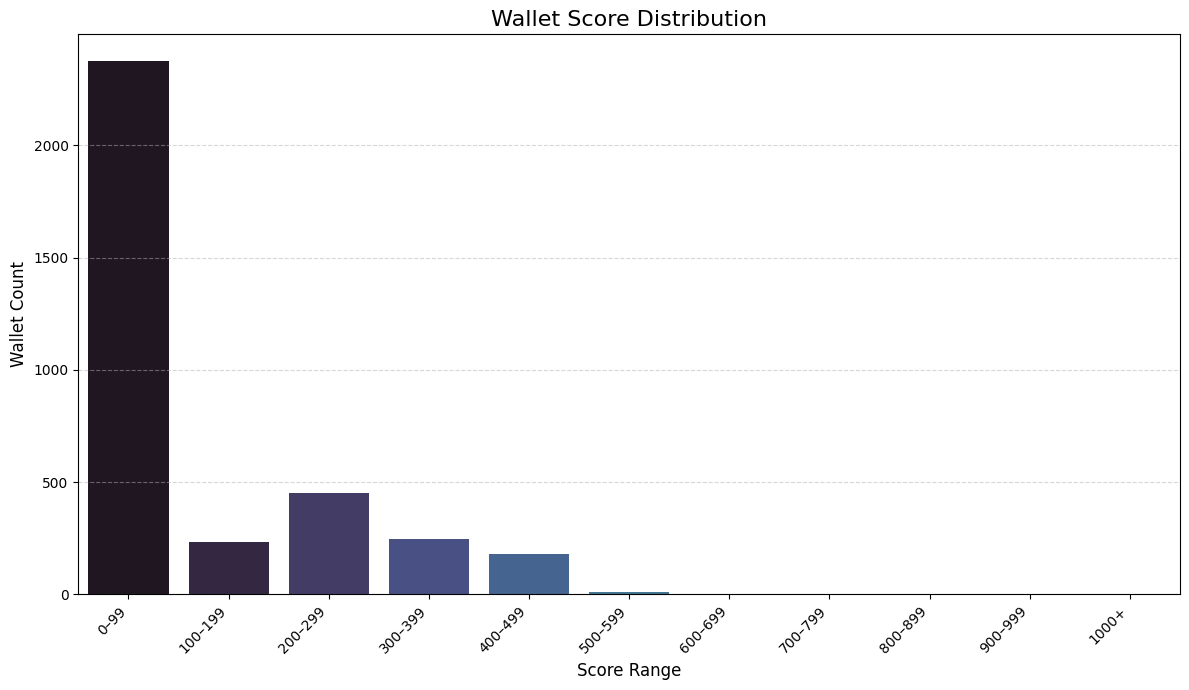

In [53]:
if 'scores' not in globals() or not scores:
    print("No score data found. Ensure earlier steps ran correctly.")
else:
    scores_series = pd.Series(scores)

    print("\nStats:")
    print(scores_series.describe())

    print("\nPlotting distribution...")

    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]
    labels = ['0–99', '100–199', '200–299', '300–399', '400–499', '500–599',
              '600–699', '700–799', '800–899', '900–999', '1000+']

    ranges = pd.cut(scores_series, bins=bins, labels=labels, right=False, include_lowest=True)
    dist = ranges.value_counts().sort_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(x=dist.index, y=dist.values, palette='mako')
    plt.title('Wallet Score Distribution', fontsize=16)
    plt.xlabel('Score Range', fontsize=12)
    plt.ylabel('Wallet Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('score_distribution.png')
    plt.show()


# 6. Wallet Behavior Analysis

In [54]:

if 'features' not in globals() or features.empty:
    print("Feature data missing. Check earlier steps.")
else:
    features['wallet_score'] = features['userWallet'].map(scores)
    sorted_features = features.sort_values('wallet_score').reset_index(drop=True)

    print("\nLowest scoring wallets:")
    display(sorted_features.head(5))

    print("\nHighest scoring wallets:")
    display(sorted_features.tail(5))

    low_thresh = 200
    high_thresh = 800

    low_group = sorted_features[sorted_features['wallet_score'] < low_thresh]
    high_group = sorted_features[sorted_features['wallet_score'] >= high_thresh]

    print(f"\nAverages — Low Score (<{low_thresh}):")
    display(low_group.select_dtypes(include='number').mean())

    print(f"\nAverages — High Score (≥{high_thresh}):")
    display(high_group.select_dtypes(include='number').mean())



Lowest scoring wallets:


,userWallet,total_transactions,first_transaction_date,last_transaction_date,num_unique_protocols,num_unique_assets,total_usd_value_all_tx,avg_usd_value_per_tx,days_since_first_tx,days_since_last_tx,days_active_span,total_borrow_usd,total_deposit_usd,total_liquidationcall_usd,total_redeemunderlying_usd,total_repay_usd,borrow_to_repay_ratio,wallet_score
0,0x061667d49211840a590513f622a92ec170de7879,1,2021-06-08 04:10:06,2021-06-08 04:10:06,1,1,5.158433e+08,5.158433e+08,1506,1506,0,0.000000e+00,5.158433e+08,0.0,0.0,0.0,0.0,0
1,0x060cd95870d75c91168f12a451d71c3231a79c66,2,2021-09-01 10:37:29,2021-09-01 10:57:24,1,2,1.585424e+16,7.927119e+15,1421,1421,0,2.250956e+03,1.585424e+16,0.0,0.0,0.0,99999.0,0
2,0x0494a6fe59e7b6db7cc4d8530f95f4f836e2100b,1,2021-05-30 01:51:07,2021-05-30 01:51:07,1,1,1.741846e+17,1.741846e+17,1515,1515,0,0.000000e+00,1.741846e+17,0.0,0.0,0.0,0.0,0
3,0x060cfcf2bd89aadaedd2f2b4760466ec1c57377c,1,2021-05-16 05:47:33,2021-05-16 05:47:33,1,1,1.656720e+17,1.656720e+17,1529,1529,0,0.000000e+00,1.656720e+17,0.0,0.0,0.0,0.0,0
4,0x060d0cc814854f60cc6ca2566a047526a85f1d9a,4,2021-08-14 19:21:29,2021-08-14 19:24:53,1,1,9.950135e+19,2.487534e+19,1439,1439,0,3.309333e+19,6.640802e+19,0.0,0.0,0.0,99999.0,0



Highest scoring wallets:


,userWallet,total_transactions,first_transaction_date,last_transaction_date,num_unique_protocols,num_unique_assets,total_usd_value_all_tx,avg_usd_value_per_tx,days_since_first_tx,days_since_last_tx,days_active_span,total_borrow_usd,total_deposit_usd,total_liquidationcall_usd,total_redeemunderlying_usd,total_repay_usd,borrow_to_repay_ratio,wallet_score
3492,0x05ebf7b089a859af295b4f4d96673edcb5ef6621,300,2021-04-21 14:45:45,2021-09-02 09:50:51,1,7,1.248768e+24,4.121348e+21,1554,1420,133,1.448051e+23,3.619220e+23,0.0,5.829303e+23,1.591111e+23,0.910088,513
3493,0x05404b6f8990a4108150366adb572a870b137edc,468,2021-04-12 16:45:43,2021-08-25 21:09:40,1,8,4.148079e+22,8.769723e+19,1563,1427,135,2.731034e+21,1.853889e+22,0.0,1.755055e+22,2.660316e+21,1.026583,515
3494,0x0553aeaaa787ca5bbca6e172d3fde33957ff4b91,67,2021-04-17 04:26:28,2021-08-31 08:14:58,1,6,7.606292e+22,1.135267e+21,1558,1422,136,2.858523e+21,4.017654e+22,0.0,3.016933e+22,2.858523e+21,1.000000,516
3495,0x03b16ab6e23bdbeeab719d8e4c49d63674876253,597,2021-04-13 16:56:03,2021-09-02 08:34:35,1,7,3.574785e+24,5.987914e+21,1562,1420,141,3.320534e+23,1.449843e+24,0.0,1.461182e+24,3.317069e+23,1.001045,521
3496,0x02aee0ce756fa0157294ff3ff48c1dd02adccf04,116,2021-04-13 15:59:03,2021-09-02 01:00:53,1,7,5.482145e+23,4.725987e+21,1562,1420,141,4.136293e+22,3.082833e+23,0.0,1.571532e+23,4.141499e+22,0.998743,521



Averages — Low Score (<200):


total_transactions            1.560613e+01
num_unique_protocols          1.000000e+00
num_unique_assets             1.785057e+00
total_usd_value_all_tx        1.579955e+23
avg_usd_value_per_tx          4.851150e+21
days_since_first_tx           1.485362e+03
days_since_last_tx            1.472740e+03
days_active_span              1.239808e+01
total_borrow_usd              3.921782e+22
total_deposit_usd             5.839693e+22
total_liquidationcall_usd     0.000000e+00
total_redeemunderlying_usd    4.282192e+22
total_repay_usd               1.755887e+22
borrow_to_repay_ratio         7.404331e+10
wallet_score                  1.748352e+01
dtype: float64


Averages — High Score (≥800):


total_transactions           NaN
num_unique_protocols         NaN
num_unique_assets            NaN
total_usd_value_all_tx       NaN
avg_usd_value_per_tx         NaN
days_since_first_tx          NaN
days_since_last_tx           NaN
days_active_span             NaN
total_borrow_usd             NaN
total_deposit_usd            NaN
total_liquidationcall_usd    NaN
total_redeemunderlying_usd   NaN
total_repay_usd              NaN
borrow_to_repay_ratio        NaN
wallet_score                 NaN
dtype: float64